# Simulating a european call option pricing

The following is a code to price an european call option. We use a monte-Carlo
approach and compare the results to the exact answer to the solution of the 
Back-Scholes equation. One can use the exact solution for calibration of the number of time-steps for 
each realiziation of the browninan motion. 

To create the brownian motion we define two classes: 
1. Random process class (randomprocess).
2. Brownian motion class which inherits form randomprocess.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

First we define a set of classes to produce Brownian motion

In [2]:
def eye(x): # Test function for which we can calculate the ito integral
    return x

class randomprocess():
    def __init__(self, numsim = 10000, nsteps = 512, Tmax = 1):
        self.numsim = numsim
        self.nsteps = nsteps
        self.Tmax = Tmax
        self.deltaT = Tmax/nsteps
        self.time = np.arange(1,self.nsteps+1)*self.deltaT
        self.steps = None
        self.path = None
        
    def statistics(self):
        # This method calculates the mean and variance of the process vs. time
        average = np.mean(self.path, axis = 0)
        variance = np.var(self.path, axis = 0)
        return average, variance

    def funcB(self, func):
        funcb = np.array(list(map(func, self.path)))
        return funcb
    
    def stochasticINT(self, func):
        delBt = np.roll(self.steps,-1)
        delBt[:,self.nsteps-1] = 0
        funcb = self.funcB(func)
        integral = np.sum(funcb*delBt, axis = 1)
        return integral

class brownian(randomprocess):
    # inherits from random process class
    def __init__(self, numsim, nsteps = 512, Tmax = 1):
        super().__init__(numsim,nsteps,Tmax)
        mat = np.triu(np.ones([self.nsteps,self.nsteps]))
        self.steps = np.random.normal(0,np.sqrt(self.deltaT),size = [self.numsim,self.nsteps])
        self.path = np.matmul(self.steps,mat)

Now we define the option variables and the parameters of the simulation

In [3]:
# Parameters of the option. 
T = 0.5            # Expiration time (time to expiry)
S0 = 550           # Initial stock price
K = 650            # strike price
r = 0.01           # risk free rate
sigma = 0.25       # volatility
mu = 1             # drfit of the stock price (not used here)

# Parameters for the simulation
num = 100          # Number of simulation batches.
numsim = 10000     # number of instances in each batch
steps = 1024       # Number of time-steps in an instance of the brownian motion

We produce the exact solution for comparison and calibraiton

In [4]:
# First we add the exact solution for comparison
d1 = np.log(S0/K)+r*T+0.5*T*(sigma**2)
d1 = d1/(sigma*np.sqrt(T))
d2 = d1 - sigma*np.sqrt(T)
exact = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
print(exact)    

10.243567407037332


Now we run the simulation

In [5]:
error = []
sum = 0
for flag in range(1,num+1):
    b = brownian(numsim,steps, T)
    BhT = b.path[:,steps-1]
    STstar = S0*np.exp(-0.5*T*(sigma**2))*np.exp(sigma*BhT)
    option = STstar - math.exp(-r*T)*K
    option = option * (option>0)
    price = np.mean(option)
    sum += price
    estimate = sum/flag    
    errornext = 100*abs((estimate - exact)/exact)    # Error percent in comparison with the exact results
    error.append(errornext)
    s = f'{flag:5}{estimate:20.12}{errornext:15.5}'
    print(s)
print(exact)

    1       11.1445341734         8.7954
    2       10.5894631267         3.3767
    3       10.5006837382           2.51
    4       10.4586476653         2.0997
    5       10.5299990461         2.7962
    6       10.4782378649         2.2909
    7       10.3806346262         1.3381
    8       10.3260559526        0.80527
    9       10.2849326884        0.40382
   10       10.2881382682        0.43511
   11       10.3180460659        0.72708
   12       10.2924223521        0.47693
   13       10.3001501973        0.55237
   14       10.2592591264        0.15319
   15        10.270992616        0.26773
   16       10.2435816471     0.00013901
   17       10.2499167074       0.061983
   18        10.230783396         0.1248
   19       10.2151636477        0.27728
   20       10.2324053448        0.10897
   21       10.2565880631        0.12711
   22       10.2532201503       0.094232
   23        10.280016228        0.35582
   24       10.2713379119         0.2711
   25       10.2

Finally we plot the error as the function of the number of simulation batches.

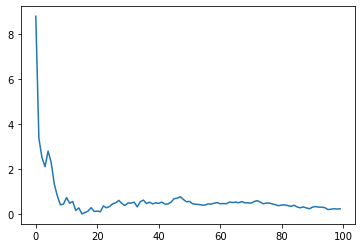

In [6]:
x = np.array(list(range(num)))
plt.plot(x, error)